In [1]:
# Data を読み込んで把握する
import pandas as pd

# Jim の利用履歴(2018/04 ~ 2019/03)の Data
uselog = pd.read_csv('sample_code/chapter_3/use_log.csv')
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


### uselog(利用履歴)
- 顧客ID、利用日を含んだ３列のみの Simple な Data.
- どの顧客がいつ Jim を利用したのかがわかる。
- 件数は、197,428件と縦に長い。

In [2]:
# 2019/03 末時点での会員 Data
customer = pd.read_csv('sample_code/chapter_3/customer_master.csv')
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


### customer(会員)
- 顧客ID、名前、会員 Class、性別、登録日等の情報が含まれている。
- 名前は Masking されており、名前だけでは個人は特定できないようになっている。
- is_delete 列は、2019年3月時点で大会している User を System 的に素早く検索するための列
   => **uselog と customer_id の紐づけが可能。**
- すでい退会済みの User も含めて4,192人。
- class, campaign_id 列を用いれば、self data と結合できる。

In [3]:
# 会員区分 Data
class_master = pd.read_csv('sample_code/chapter_3/class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


In [4]:
# Campaign 区分 Data
campaign_master = pd.read_csv('sample_code/chapter_3/campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


### 加工にあたり、主にする Data
- customer(顧客 Data)
- uselog(利用履歴)

が考えらえる。

まず、Data 数の少ない customer(顧客 Data)を主に考えていく。

一旦、uselog(利用履歴) data を置いておいて customer(顧客 Data)を整形し、どのような顧客が何人くらいいるのか等の全体像を掴む。

In [5]:
# 顧客 Data を整形する

customer_join = pd.merge(customer, class_master, on='class', how='left')
customer_join = pd.merge(customer_join, campaign_master, on='campaign_id', how='left')
customer_join

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,ナイト,6000,通常
...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4188,HD246549,XXXXX,C01,F,2019-03-14 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4189,GD037007,XXXXX,C03,M,2019-03-14 00:00:00,NaN,CA1,0,ナイト,6000,通常
4190,OA953150,XXXXX,C01,M,2019-03-14 00:00:00,NaN,CA1,0,オールタイム,10500,通常


In [6]:
print(len(customer))
print(len(customer_join))

4192
4192


会員区分や金額等がわかるように Data 整形完了。
Data 件数も、Join 前後で変化がないことを確認。

欠損値の確認をする。

In [7]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

- end_date 以外は欠損値が0
- end_date に欠損値が入っていること以外は比較的綺麗な Data.
  退会していない User は退会日である end_date を保持していないため、欠損値となっていると思われる。

顧客 Data を集計し全体像を見ていく。
- 会員区分
- Campaign 区分
- 性別
- すでに退会済みかどうか（is_deleted列）

毎に全体数を把握する。

In [8]:
# 会員区分
customer_join.groupby('class_name').count()['customer_id']

class_name
オールタイム    2045
デイタイム     1019
ナイト       1128
Name: customer_id, dtype: int64

オールタイムが約半数を占め、次いでナイト、最後にデイタイムとなっている。

In [9]:
# Campaign 区分
customer_join.groupby('campaign_name').count()['customer_id']

campaign_name
入会費半額     650
入会費無料     492
通常       3050
Name: customer_id, dtype: int64

通常入会が多く、入会キャンペーン中に入会したのはおよそ20%となっている。

In [10]:
# 性別
customer_join.groupby('gender').count()['customer_id']

gender
F    1983
M    2209
Name: customer_id, dtype: int64

男女比はわずかに男性が多い。

In [11]:
# すでに退会済みかどうか
customer_join.groupby('is_deleted').count()['customer_id']

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

退会している User は1,350人で2019年３月時点で入会している User は2,842人。

仮説や疑問点
- Campaign はいつ行われていたのか。
- 性別と会員 Class の関係
- 今年度の入会人数
- etc...

2018年４月１日から2019年３月31日までの入会人数を集計してみる。

In [12]:
customer_join['start_date'] = pd.to_datetime(customer_join['start_date'])
customer_start = customer_join.loc[customer_join['start_date'] > pd.to_datetime('20180401')]
print(len(customer_start))

1361


入会会員は1,361人で退会した人数よりも11人多いが、全体の会員数は変わらない結果となった。

最新月の顧客 Data の把握を行う。

**理由**
現在の顧客 Data は離脱している User も含まれるため単月の実態とは違いがある。
最新月の顧客 Data を集計することで現状顧客の全体像を把握する。

**方法**
1. 2019年03月(2019年03月31日）に退会した User もしくは、在籍した User で絞りこむ。
2. is_delete 列で絞り込む

1 を採用とする。

In [13]:
customer_join['end_date'] = pd.to_datetime(customer_join['end_date'])
customer_newer = customer_join.loc[
    (customer_join['end_date'] >= pd.to_datetime('20190331')) | (customer_join['end_date'].isna())]
print(len(customer_newer))
customer_newer['end_date'].unique()

2953


array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [14]:
customer_newer.groupby('class_name').count()['customer_id']

class_name
オールタイム    1444
デイタイム      696
ナイト        813
Name: customer_id, dtype: int64

In [15]:
customer_newer.groupby('campaign_name').count()['customer_id']

campaign_name
入会費半額     311
入会費無料     242
通常       2400
Name: customer_id, dtype: int64

In [16]:
customer_newer.groupby('gender').count()['customer_id']

gender
F    1400
M    1553
Name: customer_id, dtype: int64

**会員区分、性別は全体集計の比率と大きく変わっていない**
特定の会員区分や性別が退会しているわけではないと考えられる。

**Campaign 区分は全体集計と比べて若干の相違あり**

全体集計 | 最新集計
--- | ---
通常で入会している User は、72% | 通常で入会している User 81%

入会 Campaign は比率が変化するくらいに、何かしらの効果を生んでいることが推測される。

会員や性別が大きく変化しているわけではないので、**利用履歴 Data **を分析していく

**利用履歴 Data でわかること**
- 時間的な要素を分析可能
    - 月内の利用回数がどのように変化しているのか
    - 定期的に Jim を活用している User なのか
    - etc...

In [17]:
uselog

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01
...,...,...,...
197423,L00000049209753,TS977703,2019-03-31
197424,L00000049209754,TS979550,2019-03-31
197425,L00000049209755,TS995299,2019-03-31
197426,L00000049209756,TS995853,2019-03-31


In [18]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['年月'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['年月', 'customer_id'], as_index=False).count()
uselog_months.rename(columns={'log_id': 'count'}, inplace=True)
del uselog_months['usedate']
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [19]:
uselog_customer = uselog_months.groupby('customer_id').agg(['mean', 'median', 'max', 'min'])['count']
uselog_customer = uselog_customer.reset_index(drop=False)
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


顧客毎の月内の利用回数の集計が完了。

定期的に Jim を利用しえいる場合の Flag 作成を行う。

**Jim の重要な Factor**
習慣化が継続

定期的に Jim を利用している User を特定してみる。

**今回における「定期的」の定義**
毎週同じ曜日に来ているかどうかで判断とする。
顧客毎に月/曜日別に集計を行い、最大値が4以上の曜日が１ヶ月でもあった User は Flag1 とする。

In [20]:
# 顧客毎に月/曜日別に集計
uselog['weekday'] = uselog['usedate'].dt.weekday
uselog_weekday = uselog.groupby(['customer_id', '年月', 'weekday'], as_index=False).count()[
    ['customer_id', '年月', 'weekday', 'log_id']]
uselog_weekday.rename(columns={'log_id': 'count'}, inplace=True)
uselog_weekday.head()

,customer_id,年月,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


※ 曜日表

0 | 1 | 2 | 3 | 4 | 5 | 6
--- | --- | --- | --- | --- | --- | ---
月 | 火 | 水 | 木 | 金 | 土 | 日

顧客AS00285は、毎週土曜を Jim の日と考えている様子。

顧客毎の各月の最大値を取得し、その最大値が4以上の場合、Flag を立てる

In [21]:
uselog_weekday = uselog_weekday.groupby('customer_id', as_index=False).max()[['customer_id', 'count']]
uselog_weekday['routine_flg'] = 0
uselog_weekday['routine_flg'] = uselog_weekday['routine_flg'].where(uselog_weekday['count'] < 4, 1)
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


In [22]:
# 顧客 Data と利用履歴 Data を結合
customer_join = pd.merge(customer_join, uselog_customer, on='customer_id', how='left')
customer_join = pd.merge(customer_join, uselog_weekday[['customer_id', 'routine_flg']], on='customer_id', how='left')
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1


In [23]:
# 欠損値の確認
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

end_date 以外に欠損値がなく結合に問題ないことを確認とる。

In [26]:
# 会員期間を計算
from dateutil.relativedelta import relativedelta
customer_join['calc_data'] = customer_join['end_date']
customer_join['calc_data'] = customer_join['calc_data'].fillna(pd.to_datetime('20190430'))
customer_join['membership_period'] = 0
for i in range(len(customer_join)):
    delta = relativedelta(customer_join['calc_data'].iloc[i], customer_join['start_date'].iloc[i])
    customer_join['membership_period'].iloc[i] = delta.years*12 + delta.months

customer_join.head()

/home/tera/.local/share/virtualenvs/data_analysis_100_knock-wqHqPzKa/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_data,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


### 会員期間を月単位で集計
会員期間 = start_date と end_date の差
2019年03月までに退会していない User に関しては欠損値が入っている為、2019年04月として会員期間を算出。
※ 2019年03月31日にすると実際に3月31日で退会した User と区別がつかなくなるため。

In [27]:
# 顧客行動の各種統計量を把握
customer_join[['mean', 'median', 'max', 'min']].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


平均値、中央値に大きな違いはなく、顧客１名あたりおよそ５回程度の月内利用回数となっている。

In [28]:
customer_join.groupby('routine_flg').count()['customer_id']

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

定期的に利用している User の方が多い。

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

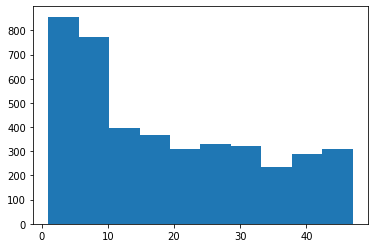

In [29]:
import matplotlib.pyplot as plt
plt.hist(customer_join['membership_period'])

### 短期で User が離れていく業界であることを示唆している。
**理由**
- 会員期間が10ヶ月以内の User の分布が多い。
- 10ヶ月以上はほぼ横這いに分布している。